In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

# from IPython import display

import os, glob
from PIL import Image

import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
import torchvision

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print('GPU available:', device)

GPU available: cuda


In [0]:
from google.colab import drive
drive.mount('/content/drive')

data_prefix = '/content/drive/Shared drives/Drive compartilhado EA999/data_augmentation'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset

O conjunto de dados que vamos usar nesta atividade foi obtido de uma competição do Kaggle, [https://www.kaggle.com/c/dogs-vs-cats/data](https://www.kaggle.com/c/dogs-vs-cats/data). Neste exemplo, utilizaremos as primeiras 1000 imagens de gatos e cachorros como conjunto de treinamento, totalizando 2000 imagens. Para validação usamos as 400 imagens seguintes de cachorros e gatos. O nosso dataset está organizado da seguinte forma:

    /data/catsdogs_fewsamples/
        train/
            dogs/
                dog.0.jpg
                dog.1.jpg
                ...
                dog.999.jpg
            cats/
                cat.0.jpg
                cat.1.jpg
                ...
                cat.999.jpg
        validation/
            dogs/
                dog.1000.jpg
                dog.1001.jpg
                ...
                dog.1399.jpg
            cats/
                cat.1000.jpg
                cat.1001.jpg
                ...
                cat.1399.jpg
            

O PyTorch oferece diversas ferramentas para carregar e pré-processar os dados de maneira bem simples.

Neste caso, vamos usar a classe `ImageFolder` para carregar as imagens de gatos e cachorros do nosso conjunto de dados:

In [0]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

rootdir = data_prefix + '/data/catsdogs_fewsamples'

dataset_train = ImageFolder(rootdir + '/train/', transform=transforms.ToTensor())
dataset_valid = ImageFolder(rootdir + '/validation/', transform=transforms.ToTensor())

print(dataset_train)
print()
print(dataset_valid)
print()

Dataset ImageFolder
    Number of datapoints: 2000
    Root location: /content/drive/Shared drives/Drive compartilhado EA999/data_augmentation/data/catsdogs_fewsamples/train/
    StandardTransform
Transform: ToTensor()

Dataset ImageFolder
    Number of datapoints: 800
    Root location: /content/drive/Shared drives/Drive compartilhado EA999/data_augmentation/data/catsdogs_fewsamples/validation/
    StandardTransform
Transform: ToTensor()



In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Podemos verificar algumas amostras para testar o carregamento dos dados:

0


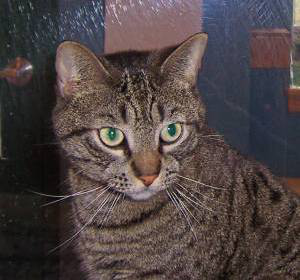

In [0]:
toPIL = transforms.ToPILImage()

image, label = dataset_train[1]
print(label)
toPIL(image)

### EXERCÍCIO 1: 
Escreva uma classe customizada para carregar o dataset de imagens descrito acima retornando uma tupla com o primento elemento sendo a imagem convertida em array e o segundo elemento a classe, gato (0) ou cachorro (1).
Inclua também uma transformação para converter as imagens em tensores.

*Lembretes:*
- *a sua classe deve herdar da classe Dataset do PyTorch*
- *é preciso redefinir os métodos* `__len__` *e* `__getitem__`

In [0]:
# torchvision.transforms.ToTensor
# Convert a PIL Image or numpy.ndarray to tensor.

# torchvision.transforms.ToPILImage(mode=None)
# Convert a tensor or an ndarray to PIL Image.

# transform=transforms.ToTensor()

In [0]:
dataset_train_path = rootdir + '/train/'
dataset_valid_path = rootdir + '/validation/'
dataset_train_path

'/content/drive/Shared drives/Drive compartilhado EA999/data_augmentation/data/catsdogs_fewsamples/train/'

In [0]:
from torch.utils.data import Dataset
from PIL import Image
import os
pil2tensor = torchvision.transforms.ToTensor()

In [0]:
class CatsAndDogs(Dataset):
    def __init__(self, path, transform=None):
        super(CatsAndDogs, self).__init__()
        self.path = path
        self.classes = os.listdir(path)
        self.transform = transform

        # get number of classes
        N_classes = len(os.listdir(path))
        filenames = []
        dataset_files = []

        # loop for each class
        for i in range(N_classes):
            class_path = os.path.join(path, self.classes[i])     # joing path
            filenames.append(os.listdir(class_path))        # read all files for that class
            dataset_files += filenames[i]
        self.dataset_files = dataset_files

        # create target array
        dataset_target = np.zeros(len(dataset_files))
        class_path = os.path.join(path, self.classes[0])     # joing path
        #===============================================
        # ONLY WORKS FOR BINARY CLASSES
        dataset_target[len(os.listdir(class_path)):] = 1
        #===============================================
        
        self.target = dataset_target

    def __len__(self):
        return len(self.dataset_files)

    def __getitem__(self, index):
        #===============================================
        # ONLY WORKS FOR BINARY CLASSES
        if index < 1000:
            new_path = self.path + 'cats/'
        else:
            new_path = self.path + 'dogs/'
        #===============================================
        image = Image.open(new_path + self.dataset_files[index])
        array = image
#        array = np.array(image)
        if self.transform:
            array = self.transform(array)
        return array, int(self.target[index])

In [0]:
dataset_train = CatsAndDogs(dataset_train_path)
print(type(dataset_train[0][0]))
dataset_train = CatsAndDogs(dataset_train_path, transform=pil2tensor)
print(type(dataset_train[0][0]))

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'torch.Tensor'>


### EXERCÍCIO 2:

Escreva uma transformação para redimensionar as imagens para tamanhos de (224, 224) e a adicione ao seu dataset.

*Dica:*
- *Use a classe Compose do PyTorch para combinar as transformações redimensionamento e conversão para tensores*,  [torchvision.transforms.Compose](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Compose)


In [0]:
class Resize(object):
    def __init__(self, output_size):
        self.output_size = output_size
    def __call__(self, data):
        im = Image.Image()
        image = data.resize(self.output_size)
        return image

In [0]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225])

In [0]:
resize_image = Resize(output_size=(224,224))
#-------------------------------------------------
transforms_list = [
    resize_image,
    pil2tensor,
    normalize,
]
#-------------------------------------------------
image_transform = torchvision.transforms.Compose(transforms_list)

torch.Size([3, 374, 500])


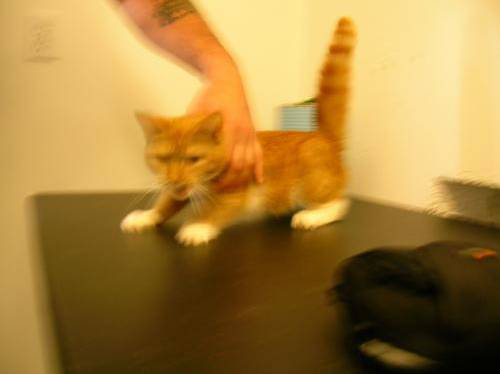

In [0]:
dataset_train = CatsAndDogs(dataset_train_path, transform=pil2tensor)
print(dataset_train[0][0].shape)
toPIL(dataset_train[0][0])

torch.Size([3, 224, 224])


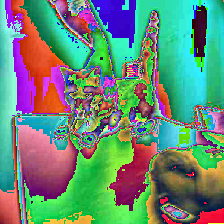

In [0]:
dataset_train = CatsAndDogs(dataset_train_path, transform=image_transform)
print(dataset_train[0][0].shape)
toPIL(dataset_train[0][0])

In [0]:
dataset_train = ImageFolder(rootdir + '/train/', transform=image_transform)
dataset_valid = ImageFolder(rootdir + '/validation/', transform=image_transform)

## DataLoader
Podemos agora definir um DataLoader para facilitar a carregamento dos dados durante o treinamento:

In [0]:
from torch.utils.data import DataLoader

In [0]:
# DataLoader for training set
dl_train = DataLoader(
    dataset_train, 
    batch_size=10,
    #drop_last = True,
    shuffle=False)
#-------------------
# DataLoader for validation set
dl_val = DataLoader(
    dataset_valid, 
    batch_size=10,
    #drop_last = True,
    shuffle=False)

### EXERCÍCIO 3:
Crie um dataloader e teste o carregamento dos dados para um *batch_size* de 20 amostras.

*Sugestão:*
- *Use a ferramenta* `torch.utils.make_grid` *para visualizar as imagens*

In [0]:
#torchvision.utils.make_grid(imgs[:10])

## Treinamento do Modelo

In [0]:
N_SAMPLES = len(dataset_train)
V_SAMPLES = len(dataset_valid)

### ResNet18

In [0]:
# importing the model
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)
#-------------------
# freeze all weights
for param in resnet18.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


### Modifying ResNet's last layer

In [0]:
resnet18.fc = torch.nn.Identity(in_features=512, out_features=512)

### Network predict

In [0]:
from torch.utils.data import TensorDataset

In [0]:
x = torch.zeros(N_SAMPLES, 512, dtype=torch.float32)
y = torch.zeros(N_SAMPLES, dtype=torch.int64)

In [0]:
# evaluation mode
resnet18.eval()
# create "new dataset"
for b_i, (b_x, b_y) in enumerate(dl_train):
    x[b_i*10:(b_i+1)*10,] = resnet18(b_x)
    y[b_i*10:(b_i+1)*10,] = b_y
    print(b_i, b_x.shape, b_y.shape, x[b_i*10:(b_i+1)*10,].shape, y[b_i*10:(b_i+1)*10,].shape)

0 torch.Size([10, 3, 224, 224]) torch.Size([10]) torch.Size([10, 512]) torch.Size([10])
1 torch.Size([10, 3, 224, 224]) torch.Size([10]) torch.Size([10, 512]) torch.Size([10])
2 torch.Size([10, 3, 224, 224]) torch.Size([10]) torch.Size([10, 512]) torch.Size([10])
3 torch.Size([10, 3, 224, 224]) torch.Size([10]) torch.Size([10, 512]) torch.Size([10])
4 torch.Size([10, 3, 224, 224]) torch.Size([10]) torch.Size([10, 512]) torch.Size([10])
5 torch.Size([10, 3, 224, 224]) torch.Size([10]) torch.Size([10, 512]) torch.Size([10])
6 torch.Size([10, 3, 224, 224]) torch.Size([10]) torch.Size([10, 512]) torch.Size([10])
7 torch.Size([10, 3, 224, 224]) torch.Size([10]) torch.Size([10, 512]) torch.Size([10])
8 torch.Size([10, 3, 224, 224]) torch.Size([10]) torch.Size([10, 512]) torch.Size([10])
9 torch.Size([10, 3, 224, 224]) torch.Size([10]) torch.Size([10, 512]) torch.Size([10])
10 torch.Size([10, 3, 224, 224]) torch.Size([10]) torch.Size([10, 512]) torch.Size([10])
11 torch.Size([10, 3, 224, 224]

In [0]:
xval = torch.zeros(V_SAMPLES, 512, dtype=torch.float32)
yval = torch.zeros(V_SAMPLES, dtype=torch.int64)

In [0]:
# evaluation mode
resnet18.eval()
# create "new dataset"
for b_i, (b_x, b_y) in enumerate(dl_val):
    xval[b_i*10:(b_i+1)*10,] = resnet18(b_x)
    yval[b_i*10:(b_i+1)*10,] = b_y
    print(b_i, b_x.shape, b_y.shape, xval[b_i*10:(b_i+1)*10,].shape, yval[b_i*10:(b_i+1)*10,].shape)

0 torch.Size([10, 3, 224, 224]) torch.Size([10]) torch.Size([10, 512]) torch.Size([10])
1 torch.Size([10, 3, 224, 224]) torch.Size([10]) torch.Size([10, 512]) torch.Size([10])
2 torch.Size([10, 3, 224, 224]) torch.Size([10]) torch.Size([10, 512]) torch.Size([10])
3 torch.Size([10, 3, 224, 224]) torch.Size([10]) torch.Size([10, 512]) torch.Size([10])
4 torch.Size([10, 3, 224, 224]) torch.Size([10]) torch.Size([10, 512]) torch.Size([10])
5 torch.Size([10, 3, 224, 224]) torch.Size([10]) torch.Size([10, 512]) torch.Size([10])
6 torch.Size([10, 3, 224, 224]) torch.Size([10]) torch.Size([10, 512]) torch.Size([10])
7 torch.Size([10, 3, 224, 224]) torch.Size([10]) torch.Size([10, 512]) torch.Size([10])
8 torch.Size([10, 3, 224, 224]) torch.Size([10]) torch.Size([10, 512]) torch.Size([10])
9 torch.Size([10, 3, 224, 224]) torch.Size([10]) torch.Size([10, 512]) torch.Size([10])
10 torch.Size([10, 3, 224, 224]) torch.Size([10]) torch.Size([10, 512]) torch.Size([10])
11 torch.Size([10, 3, 224, 224]

In [0]:
ds_transformed_train = TensorDataset(x, y)
ds_transformed_valid = TensorDataset(xval, yval)

In [0]:
# DataLoader for training set
dl_transformed_train = DataLoader(
    ds_transformed_train, 
    batch_size=100,
    #drop_last = True,
    shuffle=True)

In [0]:
# DataLoader for validation set
dl_transformed_val = DataLoader(
    ds_transformed_valid, 
    batch_size=100,
    #drop_last = True,
    shuffle=True)

### Training only last layer

In [0]:
class FC(torch.nn.Module):
    def __init__(self):
        super(FC, self).__init__()
        self.fc = torch.nn.Linear(in_features=512, out_features=2)
    def forward(self, x):
        return self.fc(x)

In [0]:
model = FC()
# Training parameters
EPOCH = 100
LR = 0.001
loss_func = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=LR)
# loss history
loss_his = []
loss_val_his = []

In [0]:
for epoch in range(EPOCH):
    print('epoch =', epoch, end='; ')
    #-------------------------------------------------
    # training
    model.train()
    zero_one_loss = 0.
    for b_i, (b_x, b_y) in enumerate(dl_transformed_train):   # for each training step
        y_logitos = model(b_x)
        loss = loss_func(y_logitos, b_y)
        opt.zero_grad()                 # clear gradients for next train
        loss.backward()                 # backpropagation, compute gradients
        opt.step()                      # apply gradients
        #-------------------
        y_pred = torch.argmax(y_logitos, dim=1)
        zero_one_loss += (b_y == y_pred).sum()
    acc_train = zero_one_loss / N_SAMPLES
    #-------------------------------------------------
    # validation
    model.eval()
    zero_one_loss_val = 0.
    for b_ival, (b_xval, b_yval) in enumerate(dl_transformed_val):
        y_logitos = model(b_xval)
        loss_val = loss_func(y_logitos, b_yval)
        yval_pred = torch.argmax(y_logitos, dim=1)
        zero_one_loss_val += (b_yval == yval_pred).sum()
    #-------------------------------------------------
    loss_his.append(loss.item())    # loss recoder
    loss_val_his.append(loss_val.item())    # loss recoder
    acc_val = zero_one_loss_val / len(ds_transformed_valid)
    #-------------------------------------------------
    print('loss_train = {0:.4f}'.format(loss_his[-1]), end='; ')
    print('loss_val = {0:.4f}'.format(loss_val_his[-1]), end='; ')
    print('acc_train = {0:.4f}'.format(acc_train), end='; ')
    print('acc_val = {0:.4f}'.format(acc_val), end='\n')

epoch = 0; loss_train = 0.4835; loss_val = 0.5019; acc_train = 0.8700; acc_val = 0.8300
epoch = 1; loss_train = 0.3415; loss_val = 0.3681; acc_train = 0.9800; acc_val = 0.9162
epoch = 2; loss_train = 0.3544; loss_val = 0.2582; acc_train = 0.8800; acc_val = 0.9475
epoch = 3; loss_train = 0.3071; loss_val = 0.2331; acc_train = 0.8800; acc_val = 0.9563
epoch = 4; loss_train = 0.2139; loss_val = 0.1923; acc_train = 0.9700; acc_val = 0.9675
epoch = 5; loss_train = 0.2166; loss_val = 0.1677; acc_train = 0.9700; acc_val = 0.9712
epoch = 6; loss_train = 0.2250; loss_val = 0.1814; acc_train = 0.9400; acc_val = 0.9725
epoch = 7; loss_train = 0.1619; loss_val = 0.1496; acc_train = 0.9600; acc_val = 0.9750
epoch = 8; loss_train = 0.1535; loss_val = 0.1447; acc_train = 0.9600; acc_val = 0.9737
epoch = 9; loss_train = 0.1398; loss_val = 0.1240; acc_train = 0.9800; acc_val = 0.9737
epoch = 10; loss_train = 0.1276; loss_val = 0.1245; acc_train = 0.9700; acc_val = 0.9737
epoch = 11; loss_train = 0.1498

### Editing ResNet's last layer

In [0]:
# change last layer
resnet18.fc = model.fc

### Calculating accuracy of whole network

In [0]:
# validation
resnet18.eval()
zero_one_loss_val = 0.
for b_ival, (b_xval, b_yval) in enumerate(dl_val):
    y_logitos = resnet18(b_xval)
    yval_sm = torch.nn.functional.softmax(y_logitos, dim=1)
    yval_pred = torch.argmax(yval_sm, dim=1)
    zero_one_loss_val += (b_yval != yval_pred).sum()
    print(b_ival, zero_one_loss_val.data)

0 tensor(0.)
1 tensor(0.)
2 tensor(0.)
3 tensor(0.)
4 tensor(1.)
5 tensor(1.)
6 tensor(1.)
7 tensor(1.)
8 tensor(1.)
9 tensor(1.)
10 tensor(1.)
11 tensor(1.)
12 tensor(1.)
13 tensor(1.)
14 tensor(1.)
15 tensor(1.)
16 tensor(1.)
17 tensor(1.)
18 tensor(2.)
19 tensor(3.)
20 tensor(3.)
21 tensor(3.)
22 tensor(3.)
23 tensor(3.)
24 tensor(3.)
25 tensor(3.)
26 tensor(4.)
27 tensor(5.)
28 tensor(5.)
29 tensor(5.)
30 tensor(6.)
31 tensor(6.)
32 tensor(6.)
33 tensor(6.)
34 tensor(6.)
35 tensor(6.)
36 tensor(7.)
37 tensor(7.)
38 tensor(7.)
39 tensor(7.)
40 tensor(7.)
41 tensor(7.)
42 tensor(8.)
43 tensor(8.)
44 tensor(8.)
45 tensor(8.)
46 tensor(9.)
47 tensor(9.)
48 tensor(9.)
49 tensor(10.)
50 tensor(10.)
51 tensor(10.)
52 tensor(10.)
53 tensor(10.)
54 tensor(10.)
55 tensor(10.)
56 tensor(11.)
57 tensor(12.)
58 tensor(12.)
59 tensor(12.)
60 tensor(12.)
61 tensor(12.)
62 tensor(12.)
63 tensor(12.)
64 tensor(12.)
65 tensor(13.)
66 tensor(13.)
67 tensor(14.)
68 tensor(14.)
69 tensor(14.)
70 tensor

In [0]:
zol = zero_one_loss_val / len(dataset_valid)
acc = 1 - zol
print('zero-one loss = {0:.4f}'.format(zol))
print('accuracy = {0:.4f}'.format(acc))

zero-one loss = 0.0175
accuracy = 0.9825


with the normalization, the accuracy was 0.9638

Fazer classificador cats and dogs usando transfer learning:
- Escolher a rede: minha sugestão resnet18 ou resnet34  
 **rede escolhida: resnet18**

- Escolher o ponto de corte da rede, estimar o tamanho do arquivo das features  
 **ponto de corte: última camada (fc)**  
 **tamanho do arquivo das features:**  
 **entrada resnet: 3 * 224 * 224 * 2000 = 301 MB**  
 **saida resnet: 512 * 512 * 2000 = 524 MB**  
- Fazer o predict das features, no conjunto de treinamento e no conjunto de validação  
 **feito na etapa "Network predict"**  
- Fazer o treinamento, com validação da(s) camada(s) final (ais) da rede de classificação cats/dogs.  
 **feito na etapa "Training only last layer"**  
- Colocar os pesos treinados nas camadas finais na rede resnet modificada  
 **feito na etapa "Editing ResNet's last layer"**  
- Fazer a avaliação da acurácia usando a rede resnet modificada no conjunto de validação: Acurácia  
 **feito na etapa "Calculating accuracy of whole network"**